In [1]:
import matplotlib.pyplot as plt
import numpy as np
import wave1D.configuration as configuration
import wave1D.finite_element_space as fe_sp
import wave1D.finite_element_operator as fe_op
import wave1D.elastic_propagator as elastic_propagator
import wave1D.lagrange_polynomial as lag_poly
import wave1D.mass_assembler as mass_assembler
import wave1D.mesh as mesh
import wave1D.stiffness_assembler as stiffness_assembler

% matplotlib inline

# Description of a model problem and its analytical solution

We consider the following 1D problem

\begin{equation*}
\left\lbrace
\begin{aligned}
& \partial^2_{tt} u - \partial^2_{xx}u= 0,\quad \text{in }]0; 1[,\\
& \partial_x u = 0,\quad \text{at } x \in \{0, 1\},\\
& u(\cdot, 0) = u_0,\quad \partial_tu(\cdot, 0) = u_1,
\end{aligned}
\right.
\end{equation*}

from which we extract analytical solution using a spectral approach. We consider the family of orthonormal eigen functions $\{e_i\}_{i\in\mathbb{N}^*}$ solution of 

\begin{equation*}
\left\lbrace
\begin{aligned}
& - \partial^2_{xx} e_i= \lambda_i e_i,\quad \text{in }]0; 1[,\\
& \partial_x e_i = 0,\quad \text{at } x \in \{0, 1\}.
\end{aligned}
\right.
\end{equation*}

After standard calculus, one can verify that

\begin{equation*}
\lambda_i = i^2\pi^2, \quad e_i(x) = \sqrt{2}cos(i\pi x), \quad \forall i \in \mathbb{N}^*.
\end{equation*}

Decomposing the solution $u(x, t)$ in this basis

\begin{equation*}
u(x, t) = \sum_{i \in\mathbb{N}^*} \xi_i(t) e_i(x),
\end{equation*}

we obtain the following set of ordinary differential equations

\begin{equation*}
\left\lbrace
\begin{aligned}
& \mathrm{d}^2_{tt} \xi_i + \lambda_i\xi_i = 0,\quad \text{in }]0; 1[,\\
& \xi_i(0) = (u_0, e_i)_{L^2(]0; 1[)},\quad \mathrm{d}_t\xi_i(0) = (u_1, e_i)_{L^2(]0; 1[)}.
\end{aligned}
\right.
\end{equation*},

that can be solved explicitly


\begin{equation*}
\xi_i(t) = (u_0, e_i)_{L^2(]0; 1[)} cos(i\pi t) + \frac{1}{\omega} (u_1, e_i)_{L^2(]0; 1[)} sin(i\pi t), \quad \forall i \in \mathbb{N}^*.
\end{equation*}

In the following, we will typically choose a spatially frequency $\kappa$ such that

\begin{equation*}
u_0 = e_\kappa, \quad u_1 = 0, 
\end{equation*}

so that finally we obtain

\begin{equation*}
u_\kappa(x, t) = \sqrt{2} cos(\kappa\pi t) cos(\kappa\pi x).
\end{equation*}


# Propagators and numerical errors computation

In [2]:
def analytical_solution(k, x, t):
    return [np.sqrt(2.0) * np.cos(k * np.pi * t) * np.cos(k * np.pi * xx) for xx in x]

In [3]:
def make_propagator(k, nelem, fe_order, fe_basis, quad_order, quad_type, mass_type, stiff_type, timestep=None, cfl_factor=None):
        
    # Creating mesh.
    msh = mesh.make_mesh_from_npt(0.0, 1.0, nelem + 1)
    
    # Creating finite element space.
    fe_space = fe_sp.FiniteElementSpace(msh, fe_order=fe_order, basis_type=fe_basis, quad_order=quad_order, quad_type=quad_type)
    
    # Creating configuration.
    config = configuration.Elastic(init_field=lambda x: np.sqrt(2.0) * np.cos(k * np.pi * x))

    # Creating propagator.
    numerical_propagator = elastic_propagator.ElasticExplicitOrderTwo(config, fe_space,
          init_cond_type=elastic_propagator.InitialConditionType.ORDERTWO,
          mass_assembly_type=mass_type,
          stiffness_assembly_type=stiff_type)
    
    # Initializing propagator.
    numerical_propagator.initialize(timestep, cfl_factor)
    
    return numerical_propagator

In [4]:
def make_equally_distributed_assembled_propagator(k, nelem, fe_order, timestep=None, cfl_factor=None):
    
    return make_propagator(k, nelem, 
            fe_order, lag_poly.PointDistributionType.EQUALLY_DISTRIBUTED,
            2 * fe_order, lag_poly.PointDistributionType.EQUALLY_DISTRIBUTED,
            fe_op.AssemblyType.ASSEMBLED, fe_op.AssemblyType.ASSEMBLED, timestep, cfl_factor)

def make_gauss_lobatto_assembled_propagator(k, nelem, fe_order, timestep=None, cfl_factor=None):
    
    return make_propagator(k, nelem, 
            fe_order, lag_poly.PointDistributionType.GAUSS_LOBATTO,
            fe_order + 1, lag_poly.PointDistributionType.GAUSS_LOBATTO,
            fe_op.AssemblyType.ASSEMBLED, fe_op.AssemblyType.ASSEMBLED, timestep, cfl_factor)

def make_gauss_lobatto_lumped_propagator(k, nelem, fe_order, timestep=None, cfl_factor=None):
    
    return make_propagator(k, nelem, 
            fe_order, lag_poly.PointDistributionType.GAUSS_LOBATTO,
            fe_order, lag_poly.PointDistributionType.GAUSS_LOBATTO,
            fe_op.AssemblyType.LUMPED, fe_op.AssemblyType.ASSEMBLED, timestep, cfl_factor)

def make_equally_distributed_lumped_propagator(k, nelem, fe_order, timestep=None, cfl_factor=None):
    
    return make_propagator(k, nelem, 
            fe_order, lag_poly.PointDistributionType.EQUALLY_DISTRIBUTED,
            fe_order, lag_poly.PointDistributionType.EQUALLY_DISTRIBUTED,
            fe_op.AssemblyType.LUMPED, fe_op.AssemblyType.ASSEMBLED, timestep, cfl_factor)

In [5]:
class Errors:
    def __init__(self):
        self.l2_l2 = []
        self.l2_h1 = []
        self.linf_l2 = []
        self.linf_h1 = []

In [6]:
def comput_errors(propagator_builder_type, k, fe_order, nelems, tmax, cfl_factor=None):

    errors = Errors()

    # Extracting minimal timestep and number of steps
    timestep = None
    if propagator_builder_type is 'EDA':
        timestep = make_equally_distributed_assembled_propagator(k, nelems[-1], fe_order, cfl_factor=cfl_factor).timestep
    elif propagator_builder_type is 'GLA':
        timestep = make_gauss_lobatto_assembled_propagator(k, nelems[-1], fe_order, cfl_factor=cfl_factor).timestep
    elif propagator_builder_type is 'GLL':
        timestep = make_gauss_lobatto_lumped_propagator(k, nelems[-1], fe_order, cfl_factor=cfl_factor).timestep
    elif propagator_builder_type is 'EDL':
        timestep = make_equally_distributed_lumped_propagator(k, nelems[-1], fe_order, cfl_factor=cfl_factor).timestep
        
    # Computing number of time steps.
    nstep = int(np.ceil(tmax / timestep))

    # Runing propagators for every discretization.
    for nelem in nelems:

        # Creating propagator.
        propagator = None
        if propagator_builder_type is 'EDA':
            propagator = make_equally_distributed_assembled_propagator(k, nelem, fe_order, timestep=timestep)
        elif propagator_builder_type is 'GLA':
            propagator = make_gauss_lobatto_assembled_propagator(k, nelem, fe_order, timestep=timestep)
        elif propagator_builder_type is 'GLL':
            propagator = make_gauss_lobatto_lumped_propagator(k, nelem, fe_order, timestep=timestep)
        elif propagator_builder_type is 'EDL':
            propagator = make_equally_distributed_lumped_propagator(k, nelem, fe_order, timestep=timestep)

        # Extracting DoF coordinates.
        dof_coords = propagator.fe_space.get_dof_coords()

        # Initializing error values.
        linf_l2_err_n = 0.0
        linf_h1_err_n = 0.0
        l2_l2_err_n = 0.0
        l2_h1_err_n = 0.0

        # Computing mass and stiffness matrices for error computations.
        mass = mass_assembler.assemble_mass(propagator.fe_space, assembly_type=fe_op.AssemblyType.ASSEMBLED)
        stiffness = stiffness_assembler.assemble_stiffness(propagator.fe_space, assembly_type=fe_op.AssemblyType.ASSEMBLED)

        # Running propagator & computing errors.
        for i in range(nstep):

            # Forwarding numerical model.
            propagator.forward()

            # Computing analytical solution.
            analytical_sol = analytical_solution(k, dof_coords, (i + 1) * propagator.timestep)

            # Computing difference between exact & numerical solution.
            delta_sol = analytical_sol - propagator.u1

            # Computing l2 & h1 space errors.
            l2_err = np.sqrt(fe_op.apply_as_linear_form(mass, delta_sol, delta_sol))
            h1_err = np.sqrt(l2_err ** 2 + fe_op.apply_as_linear_form(stiffness, delta_sol, delta_sol))

            # Computing time errors.
            linf_l2_err_n = max(linf_l2_err_n, l2_err)
            linf_h1_err_n = max(linf_h1_err_n, h1_err)
            l2_l2_err_n += propagator.timestep * (l2_err ** 2)
            l2_h1_err_n += propagator.timestep * (h1_err ** 2)

            # Swapping model.
            propagator.swap()

        # Storing error values.
        errors.l2_l2.append(np.sqrt(l2_l2_err_n))
        errors.l2_h1.append(np.sqrt(l2_h1_err_n))
        errors.linf_l2.append(linf_l2_err_n)
        errors.linf_h1.append(linf_h1_err_n)
        
    # Returning computed errors.
    return errors

# Order 3 to 5, Equally Distributed Assembled vs. Gauss-Lobatto Assembled

In [39]:
k = 10
tmax = 0.0625
cfl_factor = 0.01
nelems = range(11, 50)

# Equally distributed assembled.
EDA3 = comput_errors('EDA', k, 3, nelems, tmax, cfl_factor=cfl_factor)
EDA4 = comput_errors('EDA', k, 4, nelems, tmax, cfl_factor=cfl_factor)
EDA5 = comput_errors('EDA', k, 5, nelems, tmax, cfl_factor=cfl_factor)

# Gauss-Lobatto assembled. 
GLA3 = comput_errors('GLA', k, 3, nelems, tmax, cfl_factor=cfl_factor)
GLA4 = comput_errors('GLA', k, 4, nelems, tmax, cfl_factor=cfl_factor)
GLA5 = comput_errors('GLA', k, 5, nelems, tmax, cfl_factor=cfl_factor)

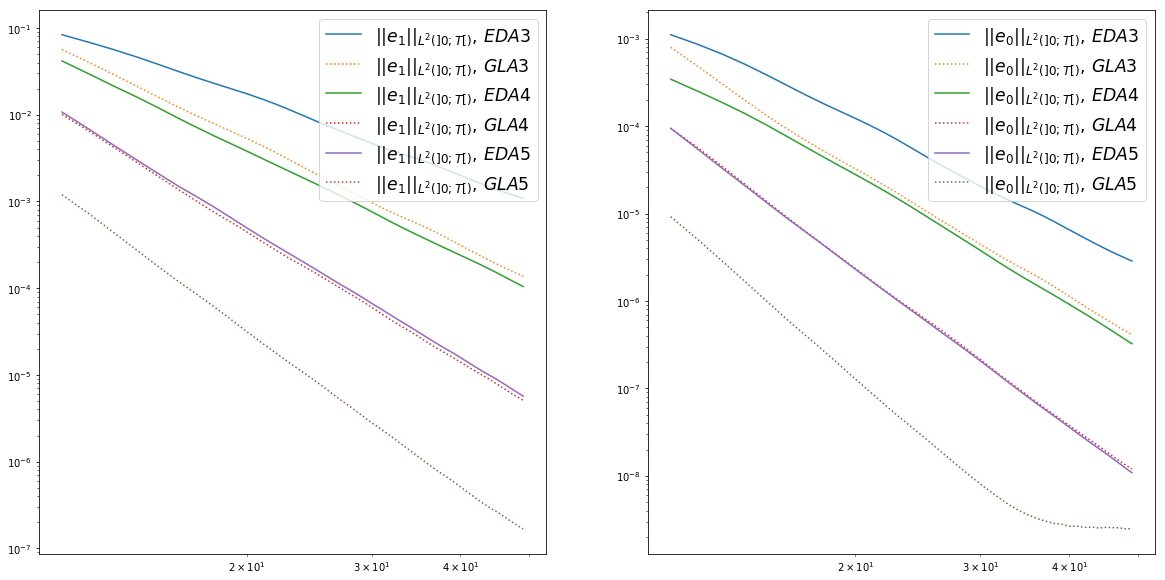

In [40]:
fig = plt.figure(figsize=(20, 10))

ax = fig.add_subplot(1, 2, 1)
ax.loglog(nelems, EDA3.l2_h1, label="$|| e_1 ||_{L^2(]0; T[)},\,EDA3$")
ax.loglog(nelems, GLA3.l2_h1, label="$|| e_1 ||_{L^2(]0; T[)},\,GLA3$", linestyle=':')
ax.loglog(nelems, EDA4.l2_h1, label="$|| e_1 ||_{L^2(]0; T[)},\,EDA4$")
ax.loglog(nelems, GLA4.l2_h1, label="$|| e_1 ||_{L^2(]0; T[)},\,GLA4$", linestyle=':')
ax.loglog(nelems, EDA5.l2_h1, label="$|| e_1 ||_{L^2(]0; T[)},\,EDA5$")
ax.loglog(nelems, GLA5.l2_h1, label="$|| e_1 ||_{L^2(]0; T[)},\,GLA5$", linestyle=':')
ax.legend(loc='upper right', fontsize='xx-large')

ax = fig.add_subplot(1, 2, 2)
ax.loglog(nelems, EDA3.l2_l2, label="$|| e_0 ||_{L^2(]0; T[)},\,EDA3$")
ax.loglog(nelems, GLA3.l2_l2, label="$|| e_0 ||_{L^2(]0; T[)},\,GLA3$", linestyle=':')
ax.loglog(nelems, EDA4.l2_l2, label="$|| e_0 ||_{L^2(]0; T[)},\,EDA4$")
ax.loglog(nelems, GLA4.l2_l2, label="$|| e_0 ||_{L^2(]0; T[)},\,GLA4$", linestyle=':')
ax.loglog(nelems, EDA5.l2_l2, label="$|| e_0 ||_{L^2(]0; T[)},\,EDA5$")
ax.loglog(nelems, GLA5.l2_l2, label="$|| e_0 ||_{L^2(]0; T[)},\,GLA5$", linestyle=':')
ax.legend(loc='upper right', fontsize='xx-large')

In [41]:
log_elems = np.log(nelems)

print(np.polyfit(log_elems, np.log(EDA3.l2_h1), 1)[0], np.polyfit(log_elems, np.log(EDA3.l2_l2), 1)[0])
print(np.polyfit(log_elems, np.log(EDA4.l2_h1), 1)[0], np.polyfit(log_elems, np.log(EDA4.l2_l2), 1)[0])
print(np.polyfit(log_elems, np.log(EDA5.l2_h1), 1)[0], np.polyfit(log_elems, np.log(EDA5.l2_l2), 1)[0])

-3.0006605376866715 -4.122412624166823
-4.0002434849268536 -4.786492540924305
-5.013247371793163 -6.041749228288918


In [42]:
log_elems = np.log(nelems)

print(np.polyfit(log_elems, np.log(GLA3.l2_h1), 1)[0], np.polyfit(log_elems, np.log(GLA3.l2_l2), 1)[0])
print(np.polyfit(log_elems, np.log(GLA4.l2_h1), 1)[0], np.polyfit(log_elems, np.log(GLA4.l2_l2), 1)[0])
print(np.polyfit(log_elems, np.log(GLA5.l2_h1), 1)[0], np.polyfit(log_elems, np.log(GLA5.l2_l2), 1)[0])

-4.043566171833281 -4.947855544501254
-5.046915469684155 -6.011674410480873
-5.969248887843278 -5.724810149381096


# Order 3 to 5, Equally Distributed Assembled vs Equally Distributed Lumped

In [44]:
k = 10
tmax = 0.0625
cfl_factor = 0.01
nelems = range(11, 50)

# Equally distributed assembled.
EDA3 = comput_errors('EDA', k, 3, nelems, tmax, cfl_factor=cfl_factor)
EDA4 = comput_errors('EDA', k, 4, nelems, tmax, cfl_factor=cfl_factor)
EDA5 = comput_errors('EDA', k, 5, nelems, tmax, cfl_factor=cfl_factor)

# Gauss-Lobatto assembled. 
EDL3 = comput_errors('EDL', k, 3, nelems, tmax, cfl_factor=cfl_factor)
EDL4 = comput_errors('EDL', k, 4, nelems, tmax, cfl_factor=cfl_factor)
EDL5 = comput_errors('EDL', k, 5, nelems, tmax, cfl_factor=cfl_factor)

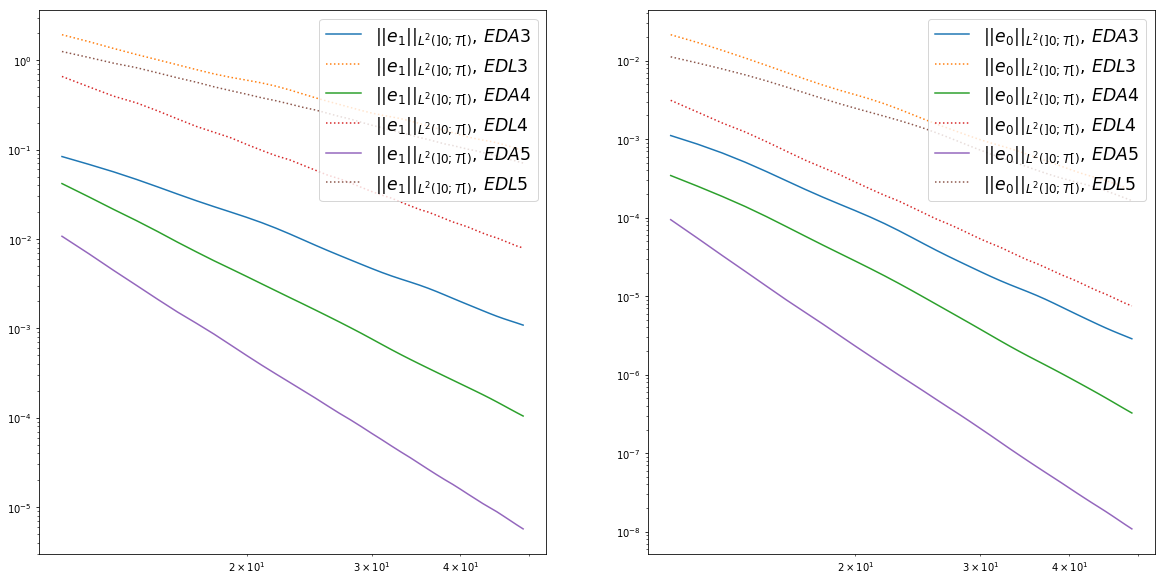

In [45]:
fig = plt.figure(figsize=(20, 10))

ax = fig.add_subplot(1, 2, 1)
ax.loglog(nelems, EDA3.l2_h1, label="$|| e_1 ||_{L^2(]0; T[)},\,EDA3$")
ax.loglog(nelems, EDL3.l2_h1, label="$|| e_1 ||_{L^2(]0; T[)},\,EDL3$", linestyle=':')
ax.loglog(nelems, EDA4.l2_h1, label="$|| e_1 ||_{L^2(]0; T[)},\,EDA4$")
ax.loglog(nelems, EDL4.l2_h1, label="$|| e_1 ||_{L^2(]0; T[)},\,EDL4$", linestyle=':')
ax.loglog(nelems, EDA5.l2_h1, label="$|| e_1 ||_{L^2(]0; T[)},\,EDA5$")
ax.loglog(nelems, EDL5.l2_h1, label="$|| e_1 ||_{L^2(]0; T[)},\,EDL5$", linestyle=':')
ax.legend(loc='upper right', fontsize='xx-large')

ax = fig.add_subplot(1, 2, 2)
ax.loglog(nelems, EDA3.l2_l2, label="$|| e_0 ||_{L^2(]0; T[)},\,EDA3$")
ax.loglog(nelems, EDL3.l2_l2, label="$|| e_0 ||_{L^2(]0; T[)},\,EDL3$", linestyle=':')
ax.loglog(nelems, EDA4.l2_l2, label="$|| e_0 ||_{L^2(]0; T[)},\,EDA4$")
ax.loglog(nelems, EDL4.l2_l2, label="$|| e_0 ||_{L^2(]0; T[)},\,EDL4$", linestyle=':')
ax.loglog(nelems, EDA5.l2_l2, label="$|| e_0 ||_{L^2(]0; T[)},\,EDA5$")
ax.loglog(nelems, EDL5.l2_l2, label="$|| e_0 ||_{L^2(]0; T[)},\,EDL5$", linestyle=':')
ax.legend(loc='upper right', fontsize='xx-large')

In [46]:
log_elems = np.log(nelems)

print(np.polyfit(log_elems, np.log(EDL3.l2_h1), 1)[0], np.polyfit(log_elems, np.log(EDL3.l2_l2), 1)[0])
print(np.polyfit(log_elems, np.log(EDL4.l2_h1), 1)[0], np.polyfit(log_elems, np.log(EDL4.l2_l2), 1)[0])
print(np.polyfit(log_elems, np.log(EDL5.l2_h1), 1)[0], np.polyfit(log_elems, np.log(EDL5.l2_l2), 1)[0])

-1.9781351968845058 -3.082970509409028
-2.9662846528006237 -4.056070742093312
-1.9448935743780185 -2.923047702956135


# Order 3 to 5, Gauss-Lobatto Assembled vs Gauss-Lobatto Lumped

In [47]:
k = 10
tmax = 0.0625
cfl_factor = 0.01
nelems = range(11, 50)

# Equally distributed assembled.
GLA3 = comput_errors('GLA', k, 3, nelems, tmax, cfl_factor=cfl_factor)
GLA4 = comput_errors('GLA', k, 4, nelems, tmax, cfl_factor=cfl_factor)
GLA5 = comput_errors('GLA', k, 5, nelems, tmax, cfl_factor=cfl_factor)

# Gauss-Lobatto assembled. 
GLL3 = comput_errors('GLL', k, 3, nelems, tmax, cfl_factor=cfl_factor)
GLL4 = comput_errors('GLL', k, 4, nelems, tmax, cfl_factor=cfl_factor)
GLL5 = comput_errors('GLL', k, 5, nelems, tmax, cfl_factor=cfl_factor)

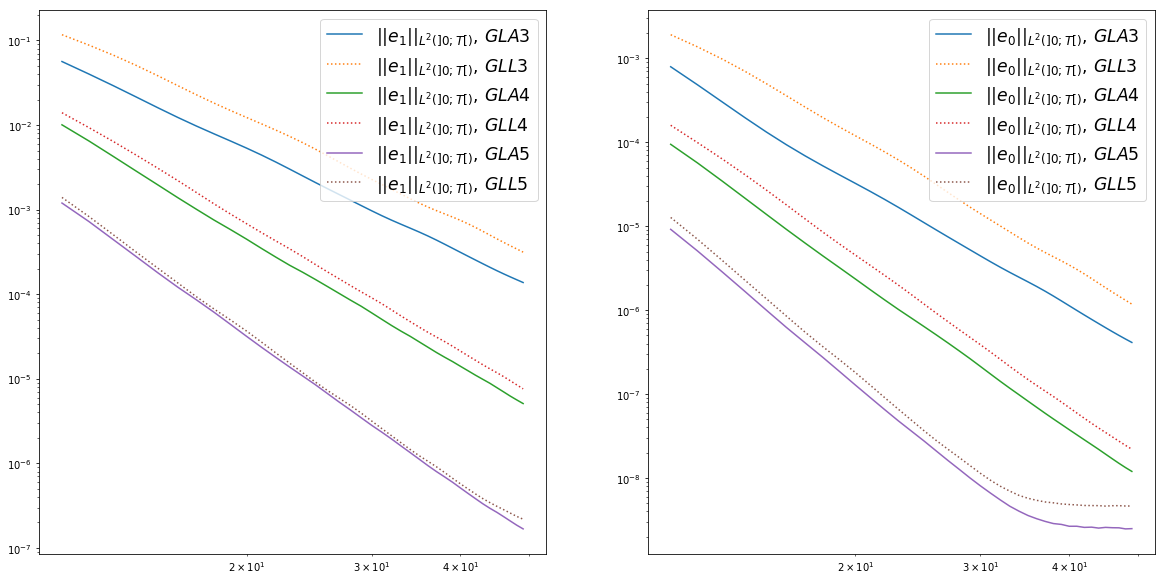

In [48]:
fig = plt.figure(figsize=(20, 10))

ax = fig.add_subplot(1, 2, 1)
ax.loglog(nelems, GLA3.l2_h1, label="$|| e_1 ||_{L^2(]0; T[)},\,GLA3$")
ax.loglog(nelems, GLL3.l2_h1, label="$|| e_1 ||_{L^2(]0; T[)},\,GLL3$", linestyle=':')
ax.loglog(nelems, GLA4.l2_h1, label="$|| e_1 ||_{L^2(]0; T[)},\,GLA4$")
ax.loglog(nelems, GLL4.l2_h1, label="$|| e_1 ||_{L^2(]0; T[)},\,GLL4$", linestyle=':')
ax.loglog(nelems, GLA5.l2_h1, label="$|| e_1 ||_{L^2(]0; T[)},\,GLA5$")
ax.loglog(nelems, GLL5.l2_h1, label="$|| e_1 ||_{L^2(]0; T[)},\,GLL5$", linestyle=':')
ax.legend(loc='upper right', fontsize='xx-large')

ax = fig.add_subplot(1, 2, 2)
ax.loglog(nelems, GLA3.l2_l2, label="$|| e_0 ||_{L^2(]0; T[)},\,GLA3$")
ax.loglog(nelems, GLL3.l2_l2, label="$|| e_0 ||_{L^2(]0; T[)},\,GLL3$", linestyle=':')
ax.loglog(nelems, GLA4.l2_l2, label="$|| e_0 ||_{L^2(]0; T[)},\,GLA4$")
ax.loglog(nelems, GLL4.l2_l2, label="$|| e_0 ||_{L^2(]0; T[)},\,GLL4$", linestyle=':')
ax.loglog(nelems, GLA5.l2_l2, label="$|| e_0 ||_{L^2(]0; T[)},\,GLA5$")
ax.loglog(nelems, GLL5.l2_l2, label="$|| e_0 ||_{L^2(]0; T[)},\,GLL5$", linestyle=':')
ax.legend(loc='upper right', fontsize='xx-large')

In [49]:
log_elems = np.log(nelems)

print(np.polyfit(log_elems, np.log(GLL3.l2_h1), 1)[0], np.polyfit(log_elems, np.log(GLL3.l2_l2), 1)[0])
print(np.polyfit(log_elems, np.log(GLL4.l2_h1), 1)[0], np.polyfit(log_elems, np.log(GLL4.l2_l2), 1)[0])
print(np.polyfit(log_elems, np.log(GLL5.l2_h1), 1)[0], np.polyfit(log_elems, np.log(GLL5.l2_l2), 1)[0])

-4.025995246945576 -5.0629560125871516
-5.051133267074486 -6.033326214140558
-5.936029481176449 -5.473638582697427


# Order 6 to 8, Equally Distributed Assembled vs Gauss-Lobatto Assembled

In [7]:
k = 10
tmax = 0.0625
cfl_factor = 0.01
nelems = range(11, 20)

# Equally distributed assembled.
EDA6 = comput_errors('EDA', k, 6, nelems, tmax, cfl_factor=cfl_factor)
EDA7 = comput_errors('EDA', k, 7, nelems, tmax, cfl_factor=cfl_factor)
EDA8 = comput_errors('EDA', k, 8, nelems, tmax, cfl_factor=cfl_factor)

# Gauss-Lobatto assembled. 
GLA6 = comput_errors('GLA', k, 6, nelems, tmax, cfl_factor=cfl_factor)
GLA7 = comput_errors('GLA', k, 7, nelems, tmax, cfl_factor=cfl_factor)
GLA8 = comput_errors('GLA', k, 8, nelems, tmax, cfl_factor=cfl_factor)

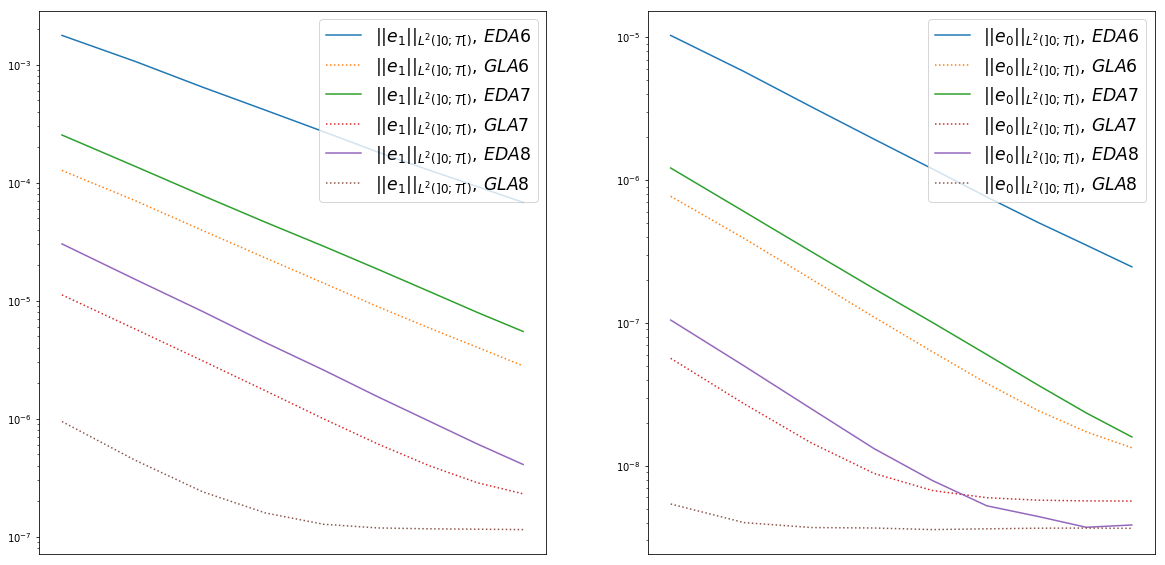

In [8]:
fig = plt.figure(figsize=(20, 10))

ax = fig.add_subplot(1, 2, 1)
ax.loglog(nelems, EDA6.l2_h1, label="$|| e_1 ||_{L^2(]0; T[)},\,EDA6$")
ax.loglog(nelems, GLA6.l2_h1, label="$|| e_1 ||_{L^2(]0; T[)},\,GLA6$", linestyle=':')
ax.loglog(nelems, EDA7.l2_h1, label="$|| e_1 ||_{L^2(]0; T[)},\,EDA7$")
ax.loglog(nelems, GLA7.l2_h1, label="$|| e_1 ||_{L^2(]0; T[)},\,GLA7$", linestyle=':')
ax.loglog(nelems, EDA8.l2_h1, label="$|| e_1 ||_{L^2(]0; T[)},\,EDA8$")
ax.loglog(nelems, GLA8.l2_h1, label="$|| e_1 ||_{L^2(]0; T[)},\,GLA8$", linestyle=':')
ax.legend(loc='upper right', fontsize='xx-large')

ax = fig.add_subplot(1, 2, 2)
ax.loglog(nelems, EDA6.l2_l2, label="$|| e_0 ||_{L^2(]0; T[)},\,EDA6$")
ax.loglog(nelems, GLA6.l2_l2, label="$|| e_0 ||_{L^2(]0; T[)},\,GLA6$", linestyle=':')
ax.loglog(nelems, EDA7.l2_l2, label="$|| e_0 ||_{L^2(]0; T[)},\,EDA7$")
ax.loglog(nelems, GLA7.l2_l2, label="$|| e_0 ||_{L^2(]0; T[)},\,GLA7$", linestyle=':')
ax.loglog(nelems, EDA8.l2_l2, label="$|| e_0 ||_{L^2(]0; T[)},\,EDA8$")
ax.loglog(nelems, GLA8.l2_l2, label="$|| e_0 ||_{L^2(]0; T[)},\,GLA8$", linestyle=':')
ax.legend(loc='upper right', fontsize='xx-large')

In [9]:
log_elems = np.log(nelems)

print(np.polyfit(log_elems, np.log(EDA6.l2_h1), 1)[0], np.polyfit(log_elems, np.log(EDA6.l2_l2), 1)[0])
print(np.polyfit(log_elems, np.log(EDA7.l2_h1), 1)[0], np.polyfit(log_elems, np.log(EDA7.l2_l2), 1)[0])
print(np.polyfit(log_elems, np.log(EDA8.l2_h1), 1)[0], np.polyfit(log_elems, np.log(EDA8.l2_l2), 1)[0])

-5.999858851057061 -6.8776607727906285
-7.008654299381769 -7.973965486592746
-7.907603389209576 -6.351459910892962


In [10]:
log_elems = np.log(nelems)

print(np.polyfit(log_elems, np.log(GLA6.l2_h1), 1)[0], np.polyfit(log_elems, np.log(GLA6.l2_l2), 1)[0])
print(np.polyfit(log_elems, np.log(GLA7.l2_h1), 1)[0], np.polyfit(log_elems, np.log(GLA7.l2_l2), 1)[0])
print(np.polyfit(log_elems, np.log(GLA8.l2_h1), 1)[0], np.polyfit(log_elems, np.log(GLA8.l2_l2), 1)[0])

-7.0270775656473825 -7.616074368095442
-7.3117141039855165 -4.097116551267543
-3.619971343906396 -0.4919767720854035
